# Project: AlGaN/AlGaN/AlN HEMT device simulation using nexnano++ and nextnanopy

## 1. General settings

In [44]:
submit_cluster = 0 # Submit the job to the cluster or not.

### 1.1 Import modules

In [45]:
if not submit_cluster:
    %reload_ext autoreload
    %autoreload 2

### 1.1.1 Adding local module path to python module search path

In [46]:
from pathlib import Path
import sys, os
current_script_path = Path().absolute()
module_path = os.path.abspath(os.path.join(current_script_path,'../..'))
sys.path.append(module_path)

#### 1.1.2 Import global modules

In [47]:
import shutil
import json
import nextnanopy as nn
from nextnanopy.utils.misc import mkdir_if_not_exist
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.tri as tri 
import pandas as pd
from matplotlib.widgets import Slider

#### 1.1.2 Import local defined modules

In [48]:
from src.PlotFunctions import general_plot_functions, Plot1DFuns, PlotQuasi3DFuns
lpltgen = general_plot_functions()
lplt1d = Plot1DFuns()
lpltq3d = PlotQuasi3DFuns()

### 1.2 Matplotlib settings

In [49]:
params = {'figure.figsize': (8, 6), 'legend.fontsize': 18, 'axes.labelsize': 24, 'axes.titlesize': 24,
          'xtick.labelsize':24, 'xtick.major.width':2, 'xtick.major.size':5, 'ytick.labelsize': 24,
          'ytick.major.width':2, 'ytick.major.size':5, 'xtick.minor.width':2, 'xtick.minor.size':3,
          'ytick.minor.width':2, 'ytick.minor.size':3, 'errorbar.capsize':2}
plt.rcParams.update(params)
plt.rc('font', size=24)

### 1.3 nextnanopy settings

In [50]:
#%% ===========================================================================
#++++++++++++++++++++++++++++++++++++++++++++++
# Software
#++++++++++++++++++++++++++++++++++++++++++++++
software_ = 'nextnano++'

#++++++++++++++++++++++++++++++++++++++++++++++
# NextNANO configuration file
#++++++++++++++++++++++++++++++++++++++++++++++
if submit_cluster:
    software_path = "/sfihome/local/rocks7-temp/codes/nextnano"
    software_executable = os.path.join(software_path, "RHEL/nextnano++_gcc_RHEL76_nextgen.exe")
    software_license = os.path.join(software_path, "License/license.txt") 
    software_database = os.path.join(software_path, "Database/database_nnp.in")
    
    nn.config.set(software_,'exe',software_executable)
    nn.config.set(software_,'runmode','--old')
    nn.config.set(software_,'license',software_license)
    nn.config.set(software_,'database',software_database)
    nn.config.set(software_,'outputdirectory','')
    
    nn.config.save() #save permanently

print(f'-nextnano config: {nn.config}')

-nextnano config: NNConfig(/home/Docs5/badal.mondal/linuxhome/.nextnanopy-config)
[nextnano++]
exe = /home/Docs5/badal.mondal/linuxhome/nextnano/2024_07_01/nextnano++/bin/nextnano++_gcc_Ubuntu.exe
license = /home/Docs5/badal.mondal/linuxhome/Licences/License_nnp.lic
database = /home/Docs5/badal.mondal/linuxhome/nextnano/2024_07_01/nextnano++/database/database_nnp.in
outputdirectory = /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations
threads = 0
[nextnano3]
exe = /home/Docs5/badal.mondal/linuxhome/nextnano/2024_07_01/nextnano3/bin/nextnano3_gcc_Ubuntu.exe
license = /home/Docs5/badal.mondal/linuxhome/Licences/License_nnp.lic
database = /home/Docs5/badal.mondal/linuxhome/nextnano/2024_07_01/nextnano3/database/database_nn3.in
threads = 0
outputdirectory = /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations
debuglevel = 0
cancel = -1
softkill = -1
[nextnano.NEGF]
exe = 
license = 
database = 
outputdirectory = 
th

### 1.4 Set tasks to perform

In [51]:
run_sim = 1 # run single simulations
run_sweep = 0 # run sweep simulations
run_sim_specific_sample = False # run single simulation for specific sample device
run_sweep_specific_sample = False # run sweep simulation for specific sample device
create_data_sweep = 0 # create required data sheet from seep simulation results
append_new_sweep_data_2_data_base = 0 # append the new sweep data to existing data files. if False, rewrite the complete excel data file.
do_plot = 1  # plot results of single simulation
do_plot_sweep = 1 # plot results of sweep simulation
savefigure = True # save the figures generated

### 1.5 Input and output directories/files

In [52]:
#++++++++++++++++++++++++++++++++++++++++++++++
# Parent simulation folder
#++++++++++++++++++++++++++++++++++++++++++++++
sim_dir = str(current_script_path).split('SCRIPTs')[0]

#++++++++++++++++++++++++++++++++++++++++++++++
# Set input file 
#++++++++++++++++++++++++++++++++++++++++++++++
# extension of the input file
FileExtension = '.in' 
# inner location of input file within INPUTs folder
folder_input_lower_level = 'AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim'
# complete path of input file folder
folder_input_ = os.path.join(sim_dir, 'INPUTs', folder_input_lower_level)
# list of name of input files
input_filename_list = [r'sim.in']
# list of all input files complete path
input_files_dest = [os.path.join(folder_input_, fname) for fname in input_filename_list]

#++++++++++++++++++++++++++++++++++++++++++++++
# Create input file for specific sample
#++++++++++++++++++++++++++++++++++++++++++++++
# settings for specific sample(s)
specific_samples = {'Sample1': {'AlContentBarrier': 0.75, 
                                'AlContentChannel': 0.55, 
                                'ThicknessAlGaNBarrier': 42}
                    }
if run_sim_specific_sample or run_sweep_specific_sample:
    # base input file to use for creating specific sample
    base_input_file = input_filename_list[0]
    base_input_file_name = base_input_file.replace(FileExtension, '')
    input_path_ = os.path.join(folder_input_, base_input_file)
    # read base input file
    input_file = nn.InputFile(input_path_)
    if (not run_sim) and (not run_sweep): 
        input_files_dest = []
    # set-update parameters for specific sample(s)
    # temporarily save generated input files
    for specific_sample_params in specific_samples.values():
        add_ftext = ''
        for key, val in specific_sample_params.items():
            input_file.set_variable(key, value=val)
            add_ftext += f'_{key}_{val:.2f}'
        input_file_specific = f'specific_sample_{base_input_file_name}_{add_ftext}.in'
        input_path_specific = os.path.join(folder_input_, 'tmp', input_file_specific)
        input_file.save(input_path_specific, overwrite=True)
        input_files_dest.append(input_path_specific)
            
#++++++++++++++++++++++++++++++++++++++++++++++
# Simulation output path
#++++++++++++++++++++++++++++++++++++++++++++++
folder_output_ = os.path.join(sim_dir, 'OUTPUTs', folder_input_lower_level)
mkdir_if_not_exist(folder_output_)

#++++++++++++++++++++++++++++++++++++++++++++++
# Postprocess data path
#++++++++++++++++++++++++++++++++++++++++++++++
folder_post_data_ = os.path.join(sim_dir, 'DATAs', folder_input_lower_level)
mkdir_if_not_exist(folder_post_data_)

#++++++++++++++++++++++++++++++++++++++++++++++
# Figure folder path
#++++++++++++++++++++++++++++++++++++++++++++++
folder_figs_ = os.path.join(sim_dir, 'FIGs', folder_input_lower_level) 
mkdir_if_not_exist(folder_figs_)

#++++++++++++++++++++++++++++++++++++++++++++++
# Specify output image format: 
# ['.pdf','.svg','.jpg','.png']
#++++++++++++++++++++++++++++++++++++++++++++++
FigFormat = '.png'
FigDpi = 75

### 1.5 Sweep parameters

In [53]:
# Specify sweep variables:
# SweepVariablesSet = {name_of_set: {sweep_variable: [start value, end value, number of points]}}
# name_of_set == name of the set. choosen by user. arbitrary. 
# sweep_variable == name of sweep variable that you want to sweep. name must be in the input file.
SweepVariablesSet = { 
    'NeumannBCEndDevice' : 
                    {'ThicknessAlNSub'          : [300, 600, 1200, 1500, 1800, 2000]},
    'SchottkyBarrierEndDevice' : 
                    {'ThicknessAlNSub'          : [300, 600, 1200, 1500, 1800, 2000]},
    'SchottkyContactScan'       : 
                    {'SchottkyBarrierHeight'    : np.linspace( 0.0,   4.0, num= 9)},
    'BandgapBowingScan'         :
                    {'AlGaNbandgapBowing'       : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]},
    'PyroelectricBowingScan'    : 
                    {'AlGaNpyroelectricBowing'  : [-0.1, -0.021, 0.0]},
    'BarrierThicknessScan' : 
                    {'ThicknessAlGaNBarrier'    : [10, 25, 50, 75, 100, 150, 200, 250, 300]},
    'ChannelThicknessScan'      : 
                    {'ThicknessAlGaNChannel'    : np.linspace(50.0, 600.0, num=23)},
    'CompositionGradLengthScan2DEG' : 
                    {'CompositionGradLength2DEG': np.linspace( 2.0,  30.0, num=15)},
    'FixBarrierCompositionGradLengthScan2DEG' : 
                    {'CompositionGradLength2DEG': np.linspace( 2.0,  20.0, num=10)},
    'TemperatureScan'           : 
                    {'Temperature'              : np.linspace(50.0, 600.0, num=23)},
    'CompositionGradLengthScan2DHG' : 
                    {'CompositionGradLength2DHG': np.linspace(50.0,  200.0, num=4)},
    'IntentionalDopingConcScanSC' : 
                {'IntentionalDopingSCConcentration': [1.0e18, 5.0e18, 1.0e19, 5.0e19, 1.0e20, 2.0e20, 
                                                      5.0e20, 1.0e21, 5.0e21, 1.0e22, 5.0e22, 1.0e23]},
    'IntentionalDopingConcScanBCB' : 
                    {'IntentionalDopingBCConcentration': [1.0e18, 5.0e18, 1.0e19, 5.0e19, 1.0e20, 2.0e20, 5.0e20, 
                                                          1.0e21, 5.0e21, 1.0e22, 5.0e22, 1.0e23]},
    'IntentionalDopingConcScanBCC' : 
                    {'IntentionalDopingBCConcentration': [1.0e18, 5.0e18, 1.0e19, 5.0e19, 1.0e20, 2.0e20, 5.0e20, 
                                                          1.0e21, 5.0e21, 1.0e22, 5.0e22, 1.0e23]},
    'CompositionBThicknessScan' : 
                    {'AlContentBarrier'         : np.linspace( 0.5,   1.0, num=11), 
                     'AlContentChannel'         : np.linspace( 0.5,   1.0, num=11),
                     'ThicknessAlGaNBarrier'    : np.linspace( 5.0,  50.0, num=10)
                     }
}
SweepVariablesSet = { 
    'NeumannBCEndDevice' : 
                    {'ThicknessAlNSub': [300, 600, 1200, 1500, 1800, 2000]},
    'SchottkyBarrierEndDevice' : 
                    {'ThicknessAlNSub': [300, 600, 1200, 1500, 1800, 2000]}   
}

# For specific samples only sweep channel thickness and composition gradient
SpecificSamplesCase = ['BarrierThicknessScan', 'ChannelThicknessScan', 'IntentionalDopingConcScanSC',
                       'IntentionalDopingConcScanBCB', 'IntentionalDopingConcScanBCC',
                       'CompositionGradLengthScan2DEG', 'TemperatureScan']

# Note: negative IntentionalDopingBCLength means doping in Barrier, positive means in Channel
# SwitchKey2: for IntentionalDopingConcScan is length of doiping region in nm
TemporaryInputFiles4 = {'SchottkyBarrierEndDevice': {'SwitchKey': 'end_device_air', 
                                                     'SwitchKey2': 1,
                                                     'input_file_name': 'end_bc_Schottky'},
                        'FixBarrierCompositionGradLengthScan2DEG': {'SwitchKey': 'EffectiveBarrier', 
                                                                    'SwitchKey2': 0,
                                                                    'input_file_name': 'fix_barrier'}, 
                        'IntentionalDopingConcScanSC': {'SwitchKey': 'IntentionalDopingSCLength', 
                                                        'SwitchKey2': 1,
                                                        'input_file_name': 'idoping'},
                        'IntentionalDopingConcScanBCB': {'SwitchKey': 'IntentionalDopingBCLength', 
                                                         'SwitchKey2': -1,
                                                         'input_file_name': 'idoping_B'},
                        'IntentionalDopingConcScanBCC': {'SwitchKey': 'IntentionalDopingBCLength', 
                                                         'SwitchKey2': 1,
                                                         'input_file_name': 'idoping_C'}}

##=============================================================================
## Functions to screen conditional sweep variables set
# Note: Nextnanopy still did not include this functionality. I locally modified my installation of
# nextnanopy to accept this function. 
# Refer to: https://github.com/nextnanopy/nextnanopy/issues/12
def condition_screen_fn(combination):
    '''
    Returns variables combination where AlContentBarrier >  AlContentChannel.
    '''
    SweepVariablesKeys = list(SweepVariables.keys())
    i_index = SweepVariablesKeys.index("AlContentBarrier")
    j_index = SweepVariablesKeys.index("AlContentChannel")
    if combination[i_index] > combination[j_index]:
        return True
    return False

def create_tmp_input_file_4_sweep(ScanVariableName, base_input_path, mapps_, FileExtension='.in'):
    # read old input file
    input_file = nn.InputFile(base_input_path)
    old_input_path = base_input_path
    # turn on composition gradient keyword
    input_file.set_variable(mapps_[ScanVariableName]['SwitchKey'], value=mapps_[ScanVariableName]['SwitchKey2'])
    input_path = os.path.join(folder_input_, 'tmp', f'{mapps_[ScanVariableName]['input_file_name']}{FileExtension}')
    input_file.save(input_path, overwrite=True)
    return old_input_path, input_path

## 2. Perform simulations

In [54]:
for input_path in input_files_dest:
    print(f"{'*'*72}")
    #==============================================================================
    # run nextnano simulation for single set of variables
    if run_sim or run_sim_specific_sample:
        print('* Running single parameter set simulation...')
        print(f'- Input file: {input_path}')
        input_file = nn.InputFile(input_path)
        # print(f"List of variables: {input_file.variables}")
        # for var in input_file.variables.values():
        #     print(f'{var.text}') 
        input_file.execute(outputdirectory=folder_output_, convergenceCheckbool=True)
    
    #==============================================================================    
    # run nextnano sweep simulation
    if run_sweep or run_sweep_specific_sample:
        print('* Running sweep simulation...')
        print(f'- Input file for Sweeping: {input_path}')
        
        #***************************************************************************
        # loop over sweep sets defined above
        for ScanVariableName, SweepVariables in SweepVariablesSet.items():
            if 'specific_sample_' in input_path and ScanVariableName not in SpecificSamplesCase:
                continue
            if ScanVariableName in TemporaryInputFiles4:
                old_input_path, input_path = create_tmp_input_file_4_sweep(ScanVariableName, input_path, 
                                                                           TemporaryInputFiles4, 
                                                                           FileExtension=FileExtension)
            print(f"{'='*52}")
            print(f'- Sweeping set: {ScanVariableName}...')
            print(f'- Sweeping variables: {list(SweepVariables.keys())}')
            sweep = nn.Sweep(SweepVariables, input_path)
            if ScanVariableName == 'CompositionBThicknessScan':
                sweep.save_sweep(delete_old_files = True, variables_comb_screen_fns=condition_screen_fn)
            else:
                sweep.save_sweep(delete_old_files = True)
            sweep.execute_sweep(delete_input_files=True, outputdirectory=folder_output_,
                                overwrite=True, convergenceCheckbool=True, show_log=False)   

            if ScanVariableName in TemporaryInputFiles4:
                input_path = old_input_path
    #==============================================================================
    # remove temporary folder
    shutil.rmtree(os.path.join(folder_input_, 'tmp'), ignore_errors=True) 
    #==============================================================================

************************************************************************
* Running single parameter set simulation...
- Input file: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/INPUTs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim.in
PREPARING...

Checking input files...


Reading environment and checking paths...

RUNNING..
Starting execution as:
/home/Docs5/badal.mondal/linuxhome/nextnano/2024_07_01/nextnano++/bin/nextnano++_gcc_Ubuntu.exe --license /home/Docs5/badal.mondal/linuxhome/Licences/License_nnp.lic --database /home/Docs5/badal.mondal/linuxhome/nextnano/2024_07_01/nextnano++/database/database_nnp.in --threads 0 --outputdirectory /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/OUTPUTs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim --noautooutdir /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/INPUTs/AlGaN_HEMT/AlGaN_AlGaN

## 3. Create post-processed data sheet from sweep simulations

In [55]:
what_to_plots = ['2DEG', '2DHG']
plot_data_files = ['integrated_density_electron.dat', 'integrated_density_hole.dat']

In [56]:
if create_data_sweep:
    for input_path in input_files_dest:
        print(f"{'*'*72}")
        input_filename = input_path.split('/')[-1]
        input_file_name_variable = input_filename.replace(FileExtension, '') 
        
        #==============================================================================
        # Set folder for post-processed data to save 
        post_processed_data_save = folder_output_.replace('OUTPUTs','DATAs')
        mkdir_if_not_exist(post_processed_data_save) 
        print(f'- Post-processed Data directory: {post_processed_data_save}')
        if append_new_sweep_data_2_data_base:
            fopen_mode = 'a'  
            if_sheet_exists='replace'
        else:
            fopen_mode = 'w'
            if_sheet_exists = None

        with pd.ExcelWriter(f'{folder_post_data_}/{input_file_name_variable}_post_process_data.xlsx', 
                            if_sheet_exists=if_sheet_exists, mode=fopen_mode,
                            engine="openpyxl") as writer:
            #==============================================================================
            # loop over sweep sets defined above
            for ScanVariableName, SweepVariables in SweepVariablesSet.items():
                if 'specific_sample_' in input_filename and ScanVariableName not in SpecificSamplesCase:
                    continue
                
                #***************************************************************************
                # Set the output folder path
                SweepVariablesKeys = list(SweepVariables.keys())
                SweepVariablesFolder ='__'.join(SweepVariablesKeys)
                
                if ScanVariableName in TemporaryInputFiles4:
                    tmp_txt = TemporaryInputFiles4[ScanVariableName]['input_file_name']
                    fname_variable_text = f'{tmp_txt}_sweep__{SweepVariablesFolder}'
                else:
                    fname_variable_text =  f'{input_file_name_variable}_sweep__{SweepVariablesFolder}'
    
                sweep_folder_path = os.path.join(folder_output_, fname_variable_text)
                print(f'- Output data folder: {sweep_folder_path}')
                print(f'- Sweep variables: {SweepVariablesKeys}')
                
                #***************************************************************************
                # Read the sweep information from the output folder
                data_folder_ = nn.DataFolder(sweep_folder_path)
                sweep_info_file = data_folder_.file('sweep_infodict.json')
                
                with open(sweep_info_file) as json_file:
                    sweep_info_data = json.load(json_file)    
                #print(f'Sweep information: {sweep_info_data}')
                
                #=============================================================================================
                df = pd.DataFrame()
                for sweep_var_file in sweep_info_data:
                    df2_dict = sweep_info_data[sweep_var_file]
                    sweep_var_value = [sweep_info_data[sweep_var_file][sweep_variable_] for sweep_variable_ in SweepVariables]
                    #s_data_folder = nn.DataFolder(sweep_var_file)
                    s_data_folder = nn.DataFolder(sweep_var_file)
                    for ii, plot_file in enumerate(plot_data_files):
                        get_file_loc = nn.DataFile(s_data_folder.file(plot_file), product=software_)
                        # integrated 2DEHG for the whole device
                        df2_dict[f'{what_to_plots[ii]}_device'] = get_file_loc.variables['Whole_Device'].value[0]
                        try:
                            # integrated 2DEHG only in the barrier-channel interface
                            df2_dict[f'{what_to_plots[ii]}_BC'] = get_file_loc.variables['Qregion_2EG'].value[0]
                            # integrated 2DEHG only in the substrate-channel interface
                            df2_dict[f'{what_to_plots[ii]}_SC'] = get_file_loc.variables['Qregion_2HG'].value[0]
                        except:
                            pass
                        
                    df = pd.concat([df, pd.DataFrame([df2_dict])], ignore_index=True)

                print(f'- Saving data sheet: {fname_variable_text}')
                df.to_excel(writer, sheet_name=fname_variable_text)
                

## 3. Plottings

### 3.1 Plot band diagram from single simulation results (** Require original simulation results)

In [57]:
# Define the region of band digram you want to zoom in
# [[xmin, xmax], [which_band(s)], [shift_yr, y_left_major_locator_distance]]
# zoom_band_diagram_regions = [[['QRegion_Left_2DEG', 'QRegion_Right_2DEG'], ['Gamma_', 'electron_Fermi_level_'], [-1, 1]],
#                              [['QRegion_Left_2DHG', 'QRegion_Right_2DHG'], ['HH_', 'LH_', 'SO_', 'electron_Fermi_level_'], [-1, 0.2]]]
zoom_band_diagram_regions = [[['EndAlGaNBarrier', 10], ['Gamma_', 'electron_Fermi_level_'], [-1, 0.4]],
                             [['EndAlGaNChannel', 10], ['HH_', 'LH_', 'SO_', 'electron_Fermi_level_'], [-1, 0.4]]]

************************************************************************
- Output data folder: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/OUTPUTs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim
- Figure folder: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim
[-0.41613638 -1.        ] [  1.40692787 202.51369421]
[-0.37911777 -1.        ] [2.45355235e-02 2.02513694e+02]


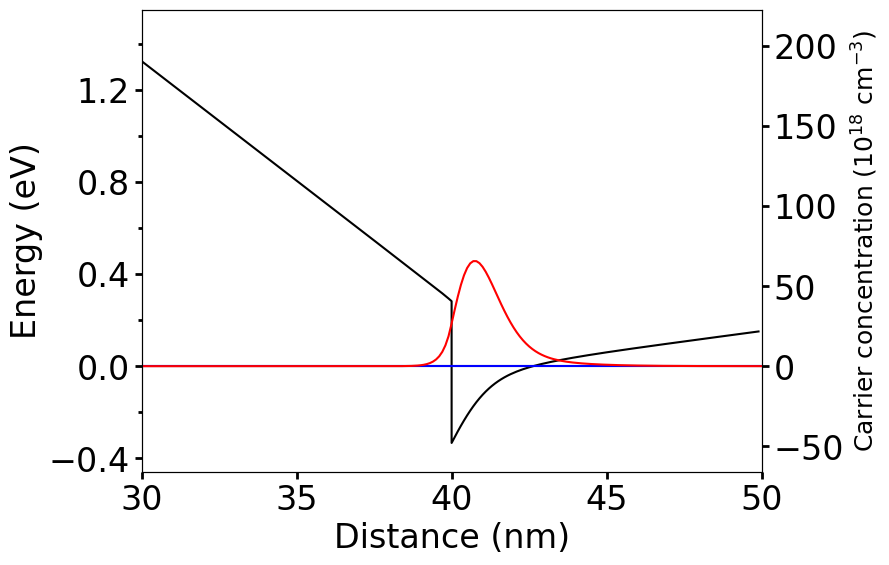

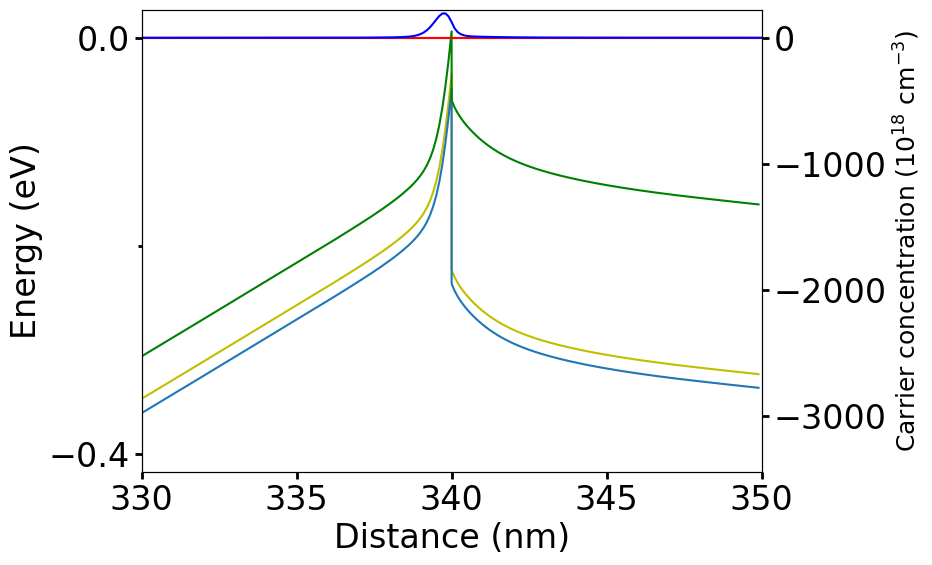

In [67]:
#%matplotlib inline 
#%matplotlib ipympl
savefigure=True
if do_plot:
    for input_path in input_files_dest:
        print(f"{'*'*72}")
        input_filename = input_path.split('/')[-1]
        input_file_name_variable = input_filename.replace(FileExtension, '')
        data_folder_ = nn.DataFolder(f'{folder_output_}/{input_file_name_variable}')
        output_figs = data_folder_.fullpath.replace('OUTPUTs','FIGs')
        print('- Output data folder:', data_folder_.fullpath)
        print('- Figure folder:', output_figs)
        #==========================================================================
        # Plot band edges + e-h desity
        lplt1d.PlotBandDiagrams(data_folder_, figs_path=output_figs, software_=software_, 
                                filename='band_edges', savefigure=savefigure,
                                FigDpi=FigDpi, FigFormat=FigFormat,
                                density_list=[('Electron_density', 'r'), ('Hole_density', 'b')],
                                plot_density=True, show_twin_yaxis_labels=False)
        #==========================================================================
        # Plot band edges + device structure
        lplt1d.PlotBandDiagrams(data_folder_, show_doping=False, show_Qregion=True, 
                                figs_path=output_figs, FigDpi=FigDpi, filename='band_edges_device_qr',
                                savefigure=savefigure, software_=software_, FigFormat=FigFormat, 
                                density_list=[('Electron_density', 'r'), ('Hole_density', 'b')],
                                plot_density=True, plot_device_sketch=True, show_twin_yaxis_labels=True)
        #==========================================================================
        # Plot band edges zoomed in the 2DEG and 2DHG regions
        i = 0
        
        for zoom_region in zoom_band_diagram_regions:
            density_list=[('Electron_density', 'r'), ('Hole_density', 'b')]
            if i == 0: density_list=density_list[-1::-1]
            fig, ax, ax0, ax2 =\
            lplt1d.PlotBandDiagrams(data_folder_, figs_path=output_figs, software_=software_, 
                                    filename=f'band_edges_zoom_r{i}', savefigure=savefigure,
                                    FigDpi=FigDpi, FigFormat=FigFormat,xaxis_n_locator=None,
                                    x_zoom_region=zoom_region[0], plot_bands=zoom_region[1],
                                    x_zoom_2nd_no_shift=True, right_yaxis_shift=zoom_region[2][0],
                                    y_left_major_locator_distance=zoom_region[2][1],
                                    density_list=density_list, plot_density=True, 
                                    show_twin_yaxis_labels=True, align_left_right_yaxis=True)
            i+=1

In [59]:
#%matplotlib inline 
#%matplotlib ipympl
savefigure=True
if do_plot:
    for input_path in input_files_dest:
        print(f"{'*'*72}")
        input_filename = input_path.split('/')[-1]
        input_file_name_variable = input_filename.replace(FileExtension, '')
        data_folder_ = nn.DataFolder(f'{folder_output_}/{input_file_name_variable}')
        output_figs = data_folder_.fullpath.replace('OUTPUTs','FIGs')
        print('- Output data folder:', data_folder_.fullpath)
        print('- Figure folder:', output_figs)
        # Plot band edges zoomed in the 2DEG and 2DHG regions
        kindex = 0
        plot_band_indices = {1:'tab:red',2:'tab:blue',3:'cyan'} #band_index, color 
        band_plot = {'Gamma_': 'quantum_2DEG_Gamma', 'HH_': 'quantum_2DHG_HH', 'kp6':'quantum_2DHG_kp6'}
        for zoom_region in zoom_band_diagram_regions:
            i = 0
            for band_index, color_ in plot_band_indices.items():
                density_list=[('PsiSqare', color_)]
                if i == 0: 
                    fig=None; ax=None; ax0=None; ax2=None
                fig, ax, ax0, ax2 = \
                    lplt1d.PlotBandDiagrams(data_folder_, fig=fig, ax=ax, ax0=ax0, ax2=ax2, 
                                            software_=software_, savefigure=False, xaxis_n_locator=None,
                                            x_zoom_region=zoom_region[0], plot_bands=zoom_region[1],
                                            x_zoom_2nd_no_shift=True, right_yaxis_shift=None,
                                            y_left_major_locator_distance=zoom_region[2][1],
                                            band_file=band_plot[zoom_region[1][0]], 
                                            band_index=band_index, kindex=kindex,
                                            subband_energy_level=True, plot_density_on_left_axis=True,
                                            density_list=density_list, plot_density=True, ylabel_twin=None,
                                            show_twin_yaxis_labels=True)
                i += 1
                    
            lpltgen.save_figs(fig, filename=f'Psi_sqr_{band_plot[zoom_region[1][0]]}', figs_path=output_figs, savefigure=savefigure,
                              FigFormat=FigFormat, FigDpi=FigDpi)

************************************************************************
- Output data folder: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/OUTPUTs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim
- Figure folder: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim


In [60]:
if do_plot:
    for input_path in input_files_dest:
        print(f"{'*'*72}")
        input_filename = input_path.split('/')[-1]
        input_file_name_variable = input_filename.replace(FileExtension, '')
        data_folder_ = nn.DataFolder(f'{folder_output_}/{input_file_name_variable}')
        output_figs = data_folder_.fullpath.replace('OUTPUTs','FIGs')
        print('- Output data folder:', data_folder_.fullpath)
        print('- Figure folder:', output_figs)
        #==========================================================================
        # Plot band edges + e-h desity
        lplt1d.PlotBandDiagrams(data_folder_, figs_path=output_figs, software_=software_, 
                                filename='band_edges_eh', savefigure=savefigure,
                                FigDpi=FigDpi, FigFormat=FigFormat,
                                density_list=[('Electron_density', 'r'), ('Hole_density', 'b')],
                                plot_density=True, show_twin_yaxis_labels=True)
        #==========================================================================
        # Plot band edges + polarization charge
        lplt1d.PlotBandDiagrams(data_folder_, figs_path=output_figs, software_=software_,
                                filename='band_edges_charges', savefigure=savefigure, 
                                density_list=[('Polarization_density', 'r')],
                                right_yaxis_shift=None,
                                plot_density=True, FigDpi=FigDpi, FigFormat=FigFormat)
        #==========================================================================
        # Plot band edges + device structure
        lplt1d.PlotBandDiagrams(data_folder_, show_doping=False, show_Qregion=False,
                                figs_path=output_figs, FigDpi=FigDpi, filename='band_edges_device',
                                savefigure=savefigure, software_=software_, FigFormat=FigFormat,
                                density_list=[('Electron_density', 'r'), ('Hole_density', 'b')],
                                plot_density=True, plot_device_sketch=True, show_twin_yaxis_labels=True)

************************************************************************
- Output data folder: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/OUTPUTs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim
- Figure folder: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim


### 3.2 Plot band diagram from sweep results (** Require original simulation results)

In [43]:
if do_plot_sweep:
    for input_path in input_files_dest:
        print(f"{'*'*72}")
        input_filename = input_path.split('/')[-1]
        input_file_name_variable = input_filename.replace(FileExtension, '')
        
        for ScanVariableName, SweepVariables in SweepVariablesSet.items():
            if 'specific_sample_' in input_filename and ScanVariableName not in SpecificSamplesCase:
                continue
            
            #=============================================================================================
            SweepVariablesKeys = list(SweepVariables.keys())  
            SweepVariablesFolder ='__'.join(SweepVariablesKeys)

            if ScanVariableName in TemporaryInputFiles4:
                tmp_txt = TemporaryInputFiles4[ScanVariableName]['input_file_name']
                sweep_folder_path = os.path.join(folder_output_, f'{tmp_txt}_sweep__{SweepVariablesFolder}')
            else:
                sweep_folder_path = os.path.join(folder_output_, f'{input_file_name_variable}_sweep__{SweepVariablesFolder}')
            
            print(f'- Output data folder: {sweep_folder_path}')
            print(f'- Sweep variables: {SweepVariablesKeys}')
            
            #=============================================================================================
            data_folder_ = nn.DataFolder(sweep_folder_path)
            sweep_info_file = data_folder_.file('sweep_infodict.json')
            
            with open(sweep_info_file) as json_file:
                sweep_info_data = json.load(json_file)   
                for sweep_folder_path_ in sweep_info_data:
                    data_folder_sweep = nn.DataFolder(sweep_folder_path_)
                    output_figs_sweep = data_folder_sweep.fullpath.replace('OUTPUTs','FIGs')
                    print(f'-- Plotting: {data_folder_sweep.fullpath}')
                    #==========================================================================
                    # Plot band edges + carrier density + device structure
                    lplt1d.PlotBandDiagrams(data_folder_sweep, show_doping=False, show_Qregion=True,
                                            figs_path=output_figs_sweep, FigDpi=FigDpi, filename='band_edges_device',
                                            savefigure=savefigure, software_=software_, FigFormat=FigFormat, 
                                            density_list=[('Electron_density', 'r'), ('Hole_density', 'b')],
                                            plot_density=True, plot_device_sketch=True, show_twin_yaxis_labels=True)
                    
                    if SweepVariablesKeys[0] in ['ThicknessAlNSub']:
                        # Plot band edges + potential + device structure
                        fig, ax, ax0, ax2 = \
                        lplt1d.PlotBandDiagrams(data_folder_sweep, show_doping=False, show_Qregion=False,
                                                software_=software_, FigFormat=FigFormat, line_alpha=0.4,
                                                density_list=[('Electron_density', 'r'), ('Hole_density', 'b')],
                                                plot_density=True, plot_device_sketch=True, show_twin_yaxis_labels=True)
                        lplt1d.PlotBandDiagrams(data_folder_sweep, fig=fig, ax=ax, 
                                                show_doping=False, show_Qregion=False,
                                                figs_path=output_figs_sweep, FigDpi=FigDpi, filename='potential',
                                                savefigure=True, software_=software_, FigFormat=FigFormat, 
                                                density_list=[('Potential', 'c')], ylabel_twin=None,
                                                plot_density=True, plot_density_on_left_axis=True,
                                                plot_device_sketch=False, right_yaxis_shift=None,
                                                show_twin_yaxis_labels=True)

                    #==========================================================================
                    if 'IntentionalDopingConcScan' in ScanVariableName:
                        # Plot band edges zoomed in the 2DEG and 2DHG regions
                        i = 0
                        for zoom_region in zoom_band_diagram_regions:
                            density_list=[('Electron_density', 'r'), ('Hole_density', 'b')]
                            if i == 0: density_list=density_list[-1::-1]
                            lplt1d.PlotBandDiagrams(data_folder_sweep, figs_path=output_figs_sweep, software_=software_, 
                                                    filename=f'band_edges_zoom_r{i}', savefigure=savefigure,
                                                    FigDpi=FigDpi, FigFormat=FigFormat,xaxis_n_locator=None,
                                                    x_zoom_region=zoom_region[0], plot_bands=zoom_region[1],
                                                    x_zoom_2nd_no_shift=True, right_yaxis_shift=zoom_region[2][0],
                                                    y_left_major_locator_distance=zoom_region[2][1],
                                                    density_list=density_list, plot_density=True, 
                                                    show_twin_yaxis_labels=True)
                            i+=1

************************************************************************
- Output data folder: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/OUTPUTs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim_sweep__ThicknessAlNSub
- Sweep variables: ['ThicknessAlNSub']
-- Plotting: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/OUTPUTs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim_sweep__ThicknessAlNSub/sim__ThicknessAlNSub_300_
-- Plotting: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/OUTPUTs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim_sweep__ThicknessAlNSub/sim__ThicknessAlNSub_600_
-- Plotting: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/OUTPUTs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim_sweep__ThicknessAlNSub/sim__ThicknessAlNSub_1200_
-- Plotting: /home/D

#### 3.2.1 Set folder path for Sweep simulations run (** Require only post-processed data file)

##### 3.2.1.1 Set mapping of x-axis labels and x-ticks locator for different sweep plots

In [11]:
rescale_2deg_fact = 1e13  # Rescalings 2DEG in 10^13 unit

In [12]:
## Map of some variables Sweep variables for plotting
# {SweepVariablesKeys: {x_label_text: ..., ticks_multiplicator: 
# [xticks major multiplicator, xticks minor multiplicator, 
# yticks major multiplicator,yticks minor multiplicator]}}
# ticks_multiplicator_plot1: only for 2DEG plot
# ticks_multiplicator_plot2: Plot both 2DEG and 2DHG in same plot
mappp_ = {'SchottkyBarrierHeight':{'x_label_text': 'Barrier height (eV)', 
                                   'ticks_multiplicator_plot1': [1.0, 0.5, 0.1, 0.05],
                                   'ticks_multiplicator_plot2': [1.0, 0.5, 0.1, 0.05]},
          'ThicknessAlNSub':{'x_label_text': 'Buffer thickness (nm)', 
                                   'ticks_multiplicator_plot1': [300, 100, None, None],
                                   'ticks_multiplicator_plot2': [300, 100, None, None]},
          'ThicknessAlGaNChannel':{'x_label_text': 'Channel thickness (nm)', 
                                   'ticks_multiplicator_plot1': [100, 50, 0.1, 0.05],
                                   'ticks_multiplicator_plot2': [100, 50, 0.2, 0.1]},
          'ThicknessAlGaNBarrier':{'x_label_text': 'Barrier thickness (nm)', 
                                   'ticks_multiplicator_plot1': [50, 25, None, None],
                                   'ticks_multiplicator_plot2': [50, 25, None, None]},
          'CompositionGradLength2DEG':{'x_label_text': 'Composition gradient (nm)', 
                                   'ticks_multiplicator_plot1': [4, 2, None, None],
                                   'ticks_multiplicator_plot2': [4, 2, None, None]},
          'CompositionGradLength2DHG':{'x_label_text': 'Composition gradient (nm)', 
                                   'ticks_multiplicator_plot1': [50, 25, None, None],
                                   'ticks_multiplicator_plot2': [50, 25, None, None]},
          'Temperature':{'x_label_text': 'Temperature (K)', 
                                   'ticks_multiplicator_plot1': [100, 50, None, None],
                                   'ticks_multiplicator_plot2': [100, 50, None, None]},
          'AlGaNbandgapBowing':{'x_label_text': 'Bandgap bowing (eV)', 
                                   'ticks_multiplicator_plot1': [0.2, 0.1, None, None],
                                   'ticks_multiplicator_plot2': [0.2, 0.1, 0.1, 0.05]},
         'AlGaNpyroelectricBowing':{'x_label_text': 'Pyroelectric bowing', 
                                   'ticks_multiplicator_plot1': [0.1, 0.1, 0.2, 0.1],
                                   'ticks_multiplicator_plot2': [0.1, 0.1, 0.5, 0.25]},
         'IntentionalDopingSCConcentration': {'x_label_text': 'Doping concentration ($\\mathrm{cm}^{-3}$)', 
                                   'ticks_multiplicator_plot1': [None, None, 1, 0.5],
                                   'ticks_multiplicator_plot2': [None, None, 1, 0.5]},
         'IntentionalDopingBCConcentration': {'x_label_text': 'Doping concentration ($\\mathrm{cm}^{-3}$)', 
                                   'ticks_multiplicator_plot1': [None, None, 0.5, 0.25],
                                   'ticks_multiplicator_plot2': [None, None, 0.5, 0.25]}}

##### 3.2.1.2 Plot 1D sweep variables vs property (e.g. 2DEG density)

In [26]:
if do_plot_sweep:
    y_label_text1 = '2DEG density ($10^{13}$ $\\mathrm{cm}^{-2}$)'
    y_label_text1_H = '2DHG density ($10^{13}$ $\\mathrm{cm}^{-2}$)'
    y_label_text2 = '2DEHG density ($10^{13}$ $\\mathrm{cm}^{-2}$)'
    for input_path in input_files_dest:
        print(f"{'*'*72}")
        input_filename = input_path.split('/')[-1]
        input_file_name_variable = input_filename.replace(FileExtension, '')  
        excel_file = f'{folder_post_data_}/{input_file_name_variable}_post_process_data.xlsx'        
        #==============================================================================
        # loop over sweep sets defined above
        for ScanVariableName, SweepVariables in SweepVariablesSet.items():
            if 'specific_sample_' in input_filename and ScanVariableName not in SpecificSamplesCase:
                continue
            if ScanVariableName in ['CompositionBThicknessScan']: continue
            #***************************************************************************
            # Set the output folder path
            SweepVariablesKeys = list(SweepVariables.keys())
            SweepVariablesFolder ='__'.join(SweepVariablesKeys) 

            if ScanVariableName in TemporaryInputFiles4:
                tmp_txt = TemporaryInputFiles4[ScanVariableName]['input_file_name']
                data_sheet_name = f'{tmp_txt}_sweep__{SweepVariablesFolder}'
            else:
                data_sheet_name =  f'{input_file_name_variable}_sweep__{SweepVariablesFolder}'
                
            print(f'- Reading data sheet: {data_sheet_name}')
            #=============================================================================================
            # Set figures directory
            output_figs_sweep = os.path.join(folder_output_,data_sheet_name).replace('OUTPUTs','FIGs')
            mkdir_if_not_exist(output_figs_sweep) 
            print(f'- Figs directory: {output_figs_sweep}')
            # #=============================================================================================
            df = pd.read_excel(excel_file, sheet_name=data_sheet_name, index_col=0)
            #=============================================================================================
            x_label_text = mappp_.get(SweepVariablesKeys[0])['x_label_text']
            ticks_multiplicator_plot1 = mappp_.get(SweepVariablesKeys[0])['ticks_multiplicator_plot1']
            ticks_multiplicator_plot2 = mappp_.get(SweepVariablesKeys[0])['ticks_multiplicator_plot2']
            #=============================================================================================
            # SC: Substrate-channel 2DHG QW region
            # BC: Barrier-channel 2DEG WQ region
            # device: whole region
            if ScanVariableName in ['IntentionalDopingConcScanSC', 
                                    'IntentionalDopingConcScanBCB', 
                                    'IntentionalDopingConcScanBCC']: 
                which_regions_to_plot = ['SC', 'BC', 'device'] 
                x_log_scale = True
                fname_save_fig_extra = ''
            else:
                which_regions_to_plot = ['device'] 
                x_log_scale = False
                fname_save_fig_extra = ''
            #=============================================================================================
            XX = df[SweepVariablesKeys[0]]
            for JJJ in which_regions_to_plot:
                YY_2DEG =  df[f'2DEG_{JJJ}'].copy()/rescale_2deg_fact
                YY_2DHG =  df[f'2DHG_{JJJ}'].copy()/rescale_2deg_fact
                #=============================================================================================
                # Plot only 2DEG
                lplt1d.PlotSweepsData(XX, YY_2DEG, x_label=x_label_text, y_label=y_label_text1,
                                      tick_multiplicator=ticks_multiplicator_plot1,
                                      FigDpi=FigDpi, FigFormat=FigFormat,
                                      figs_path=output_figs_sweep, filename=f'2DEG_{JJJ}', 
                                      savefigure=savefigure, x_log_scale=x_log_scale)
                #=============================================================================================
                if SweepVariablesKeys[0] in ['ThicknessAlNSub']:
                    # Plot only 2DHG
                    lplt1d.PlotSweepsData(XX, YY_2DHG, x_label=x_label_text, y_label=y_label_text1_H,
                                          tick_multiplicator=ticks_multiplicator_plot1,
                                          FigDpi=FigDpi, FigFormat=FigFormat,color='b',
                                          figs_path=output_figs_sweep, filename=f'2DHG_{JJJ}', 
                                          savefigure=savefigure, x_log_scale=x_log_scale)
                #=============================================================================================
                # Plot 2DEG and 2DHG
                fig, ax = lplt1d.PlotSweepsData(XX, YY_2DEG)
                fig, ax = lplt1d.PlotSweepsData(XX, YY_2DHG,
                                                fig=fig, ax=ax, x_label=x_label_text, y_label=y_label_text2,
                                                tick_multiplicator=ticks_multiplicator_plot2,
                                                FigDpi=FigDpi, FigFormat=FigFormat, color='b',
                                                figs_path=output_figs_sweep, filename=f'2DEHG_{JJJ}',
                                                savefigure=True, x_log_scale=x_log_scale)
                #=============================================================================================

************************************************************************
- Reading data sheet: sim_sweep__ThicknessAlNSub
- Figs directory: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim_sweep__ThicknessAlNSub
- Reading data sheet: end_bc_Schottky_sweep__ThicknessAlNSub
- Figs directory: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/end_bc_Schottky_sweep__ThicknessAlNSub
- Reading data sheet: sim_sweep__SchottkyBarrierHeight
- Figs directory: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim_sweep__SchottkyBarrierHeight
- Reading data sheet: sim_sweep__AlGaNbandgapBowing
- Figs directory: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimul

In [32]:
if do_plot_sweep:
    y_label_text1 = '2DEG density ($10^{13}$ $\\mathrm{cm}^{-2}$)'
    y_label_text1_H = '2DHG density ($10^{13}$ $\\mathrm{cm}^{-2}$)'
    y_label_text2 = '2DEHG density ($10^{13}$ $\\mathrm{cm}^{-2}$)'
    for input_path in input_files_dest:
        print(f"{'*'*72}")
        input_filename = input_path.split('/')[-1]
        input_file_name_variable = input_filename.replace(FileExtension, '')  
        excel_file = f'{folder_post_data_}/{input_file_name_variable}_post_process_data.xlsx'        
        #==============================================================================
        # loop over sweep sets defined above
        ii = 0; tmp_savefig=False
        for ScanVariableName in ['SchottkyBarrierEndDevice', 'NeumannBCEndDevice']:
            if 'specific_sample_' in input_filename and ScanVariableName not in SpecificSamplesCase:
                continue
            SweepVariables = SweepVariablesSet[ScanVariableName]
            #***************************************************************************
            # Set the output folder path
            SweepVariablesKeys = list(SweepVariables.keys())
            SweepVariablesFolder ='__'.join(SweepVariablesKeys) 

            if ScanVariableName in TemporaryInputFiles4:
                tmp_txt = TemporaryInputFiles4[ScanVariableName]['input_file_name']
                data_sheet_name = f'{tmp_txt}_sweep__{SweepVariablesFolder}'
            else:
                data_sheet_name =  f'{input_file_name_variable}_sweep__{SweepVariablesFolder}'
                
            print(f'- Reading data sheet: {data_sheet_name}')
            #=============================================================================================
            # Set figures directory
            output_figs_sweep = os.path.join(folder_output_,data_sheet_name).replace('OUTPUTs','FIGs')
            mkdir_if_not_exist(output_figs_sweep) 
            print(f'- Figs directory: {output_figs_sweep}')
            # #=============================================================================================
            df = pd.read_excel(excel_file, sheet_name=data_sheet_name, index_col=0)
            #=============================================================================================
            x_label_text = mappp_.get(SweepVariablesKeys[0])['x_label_text']
            ticks_multiplicator_plot1 = mappp_.get(SweepVariablesKeys[0])['ticks_multiplicator_plot1']
            ticks_multiplicator_plot2 = mappp_.get(SweepVariablesKeys[0])['ticks_multiplicator_plot2']
            #=============================================================================================
            which_regions_to_plot = ['device'] 
            x_log_scale = False
            fname_save_fig_extra = ''
            #=============================================================================================
            XX = df[SweepVariablesKeys[0]]
            for JJJ in which_regions_to_plot:
                YY_2DHG =  df[f'2DHG_{JJJ}'].copy()/rescale_2deg_fact
                #=============================================================================================
                # Plot 2DEG and 2DHG
                if ii in [0]: 
                    fig, ax = lplt1d.PlotSweepsData(XX, YY_2DHG)
                    line_style = '-'
                else:
                    tmp_savefig = True
                    line_style = '--'
                fig, ax = lplt1d.PlotSweepsData(XX, YY_2DHG, fig=fig, ax=ax,
                                                x_label=x_label_text, y_label=y_label_text1_H,
                                                tick_multiplicator=ticks_multiplicator_plot1,
                                                FigDpi=FigDpi, FigFormat=FigFormat,color='b',
                                                line_style=line_style,
                                                figs_path=output_figs_sweep, filename=f'2DHG_compare_{JJJ}',
                                                savefigure=tmp_savefig, x_log_scale=x_log_scale)
                #=============================================================================================
            ii += 1

************************************************************************
- Reading data sheet: end_bc_Schottky_sweep__ThicknessAlNSub
- Figs directory: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/end_bc_Schottky_sweep__ThicknessAlNSub
- Reading data sheet: sim_sweep__ThicknessAlNSub
- Figs directory: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim_sweep__ThicknessAlNSub


##### 3.2.1.3 Plot 3D sweep variables vs property (e.g. 2DEG density)

In [28]:
if do_plot_sweep:
    for input_path in input_files_dest:
        print(f"{'*'*72}")
        input_filename = input_path.split('/')[-1]
        input_file_name_variable = input_filename.replace(FileExtension, '')  
        excel_file = f'{folder_post_data_}/{input_file_name_variable}_post_process_data.xlsx'
        #==============================================================================
        # loop over sweep sets defined above
        ScanVariableNamesList = ['CompositionBThicknessScan']
        for ScanVariableName in ScanVariableNamesList:
            SweepVariables = SweepVariablesSet[ScanVariableName]
            if 'specific_sample_' in input_filename and ScanVariableName not in SpecificSamplesCase:
                continue
            #***************************************************************************
            # Set the output folder path
            SweepVariablesKeys = list(SweepVariables.keys())
            SweepVariablesFolder ='__'.join(SweepVariablesKeys)
            data_sheet_name =  f'{input_file_name_variable}_sweep__{SweepVariablesFolder}'
            print(f'- Reading data sheet: {data_sheet_name}')
            #=============================================================================================
            # Set figures directory
            output_figs_sweep = os.path.join(folder_output_,data_sheet_name).replace('OUTPUTs','FIGs')
            mkdir_if_not_exist(output_figs_sweep) 
            print(f'- Figs directory: {output_figs_sweep}')
        
            #=============================================================================================
            df = pd.read_excel(excel_file, sheet_name=data_sheet_name, index_col=0)
            df['2DEG_device_rescale'] =  df['2DEG_device'].copy()/rescale_2deg_fact
            df['2DHG_device_rescale'] =  df['2DHG_device'].copy()/rescale_2deg_fact
            
            df_cap_thickness_group = df.groupby(['ThicknessAlGaNBarrier']) # Group by thickness
            x_label_text = 'Al composition contrast'
            z_label_text = 'Barrier thickness (nm)'
            y_label_text = ['2DEG density ($10^{13}$ $\\mathrm{cm}^{-2}$)',
                            '2DHG density ($10^{13}$ $\\mathrm{cm}^{-2}$)']
            
            output_dataframe = {} 
            fig1, ax1 = plt.subplots()
            fig2, ax2 = plt.subplots()
            fig = [fig1, fig2]
            ax = [ax1, ax2]
            for name, group in df_cap_thickness_group:
                output_dataframe[f'{name[0]:.2f}'] = {}
                for iii, what_to_plot in enumerate(what_to_plots):
                    ##### Generate data 
                    if '2DEG' in what_to_plot:
                        group['AlContentContrast'] = (group['AlContentBarrier'] - group['AlContentChannel']) #/ group['AlContentChannel']
                    elif '2DHG' in what_to_plot:
                        group['AlContentContrast'] = (1 - group['AlContentChannel']) #/ group['AlContentSubstrate']
                    else:
                        raise AttributeError('Noting to plot')

                    #=====================================================================================
                    ax[iii].scatter(group['AlContentContrast'], group[f'{what_to_plot}_device_rescale'], label=f'{name[0]:.2f} nm')
                    
                    #=====================================================================================
                    tmp_df = group[group[f'{what_to_plot}_device_rescale']>0.01]
                    A = np.vstack([tmp_df['AlContentContrast'], np.ones(len(tmp_df))]).T
                    m, c = np.linalg.lstsq(A, tmp_df[f'{what_to_plot}_device_rescale'])[0]
                    y_eq_zero_point = -c/m
                    output_dataframe[f'{name[0]:.2f}'][f'{what_to_plot}_slope']       = f'{m:.3f}' 
                    output_dataframe[f'{name[0]:.2f}'][f'{what_to_plot}_y_intersect'] = f'{c:.3f}'
                    output_dataframe[f'{name[0]:.2f}'][f'{what_to_plot}_x_intersect'] = f'{y_eq_zero_point:.3f}'
                    new_x = np.insert(np.array(tmp_df['AlContentContrast']),0,y_eq_zero_point)
                    ax[iii].plot(new_x, m*new_x + c, 'gray')
                    
                    ax[iii].legend(ncols=1, labelspacing=0.001, columnspacing=0.1, handletextpad=0.01)
                    ax[iii].set_xlabel(x_label_text)
                    ax[iii].set_ylabel(y_label_text[iii])
                    ax[iii].axhline(color='k',ls='--')
            #=============================================================================================
            for iii, what_to_plot in enumerate(what_to_plots):
                lplt1d._save_figs(fig[iii], filename=f'Comp_contrast_thickness_{what_to_plot}', 
                                  figs_path=f'{output_figs_sweep}/Others', savefigure=savefigure, 
                                  FigDpi=FigDpi, FigFormat=FigFormat)          

            #=============================================================================================
            output_data = pd.DataFrame.from_dict(output_dataframe, orient='index', dtype=float)
            ## Plot cut-off composition contrast for each barrier thickness
            tick_multiplicator = [10,5,0.1, 0.05]
            XX = np.array(output_data.index, dtype=float)
            YY = np.array(output_data['2DEG_x_intersect'], dtype=float)
            _ = lplt1d.PlotSweepsData(XX, YY, x_label=z_label_text, y_label=x_label_text,
                                      tick_multiplicator=tick_multiplicator,
                                      FigDpi=FigDpi, FigFormat=FigFormat, color='k', marker='o',
                                      figs_path=f'{output_figs_sweep}/Others', filename=f'Critical_comp_contrast_2DEG',
                                      savefigure=savefigure)

************************************************************************
- Reading data sheet: sim_sweep__AlContentBarrier__AlContentChannel__ThicknessAlGaNBarrier
- Figs directory: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim_sweep__AlContentBarrier__AlContentChannel__ThicknessAlGaNBarrier


In [24]:
if do_plot_sweep:
    for input_path in input_files_dest:
        print(f"{'*'*72}")
        input_filename = input_path.split('/')[-1]
        input_file_name_variable = input_filename.replace(FileExtension, '')  
        excel_file = f'{folder_post_data_}/{input_file_name_variable}_post_process_data.xlsx'
        #==============================================================================
        # loop over sweep sets defined above
        ScanVariableNamesList = ['CompositionBThicknessScan']
        for ScanVariableName in ScanVariableNamesList:
            SweepVariables = SweepVariablesSet[ScanVariableName]
            if 'specific_sample_' in input_filename and ScanVariableName not in SpecificSamplesCase:
                continue
            #***************************************************************************
            # Set the output folder path
            SweepVariablesKeys = list(SweepVariables.keys())
            SweepVariablesFolder ='__'.join(SweepVariablesKeys)
            data_sheet_name =  f'{input_file_name_variable}_sweep__{SweepVariablesFolder}'
            print(f'- Reading data sheet: {data_sheet_name}')
            #=============================================================================================
            # Set figures directory
            output_figs_sweep = os.path.join(folder_output_,data_sheet_name).replace('OUTPUTs','FIGs')
            mkdir_if_not_exist(output_figs_sweep) 
            print(f'- Figs directory: {output_figs_sweep}')
        
            #=============================================================================================
            df = pd.read_excel(excel_file, sheet_name=data_sheet_name, index_col=0)
            df['2DEG_device_rescale'] =  df['2DEG_device'].copy()/rescale_2deg_fact
            df['2DHG_device_rescale'] =  df['2DHG_device'].copy()/rescale_2deg_fact
            
            df_cap_thickness_group = df.groupby(['ThicknessAlGaNBarrier']) # Group by thickness
            x_label_text = 'Al composition channel'
            y_label_text = 'Al composition barrier'
            z_label_unit = r'($10^{13}$ $\mathrm{cm}^{-2}$)'
            for iii, what_to_plot in enumerate(what_to_plots):
                vmin, vmax = df[f'{what_to_plot}_device_rescale'].min(), df[f'{what_to_plot}_device_rescale'].max()
                norm, cbar_mapable = lpltq3d.CreateColorbarMapableObject(vmin=vmin, vmax=vmax, color_map=color_map)
                for name, group in df_cap_thickness_group:
                    print(f'- Plotting barrier thickness - {what_to_plot} = {name[0]:.2f} nm')
                    ##### Generate data with interpolation
                    XX, YY, ZZ = group['AlContentChannel'], group['AlContentBarrier'], group[f'{what_to_plot}_device_rescale']
                    xi, yi, zi = lpltq3d.InterPolation(group['AlContentChannel'], 
                                                       group['AlContentBarrier'],
                                                       group[f'{what_to_plot}_device_rescale'],
                                                       method='linear', interpolation_points=20)
    
                    ##### Plot composition map vs 2DEG
                    output_figs_sweep_tmp = os.path.join(output_figs_sweep, what_to_plot)
                    fig, ax = lpltq3d.PlotContour(xi, yi, zi, vmin=vmin, vmax=vmax, 
                                                  x_label=x_label_text, y_label=y_label_text,
                                                  z_label=z_label_text[iii],
                                                  tick_multiplicator=[0.1, 0.05, 0.1, 0.05],
                                                  title_label=f"Barrier thickness = {name[0]:.2f} nm", 
                                                  cbar_mappable=cbar_mapable, norm=norm,
                                                  show_contour_lines=True,
                                                  cbar_text=f'{what_to_plot} density {z_label_unit}',
                                                  filename= f'Barrier_{name[0]:.2f}',
                                                  FigDpi=FigDpi, FigFormat=FigFormat, 
                                                  figs_path=output_figs_sweep_tmp,
                                                  savefigure=savefigure)

************************************************************************
- Reading data sheet: sim_sweep__AlContentBarrier__AlContentChannel__ThicknessAlGaNBarrier
- Figs directory: /home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/FIGs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/2DEHG_density/OneDim/sim_sweep__AlContentBarrier__AlContentChannel__ThicknessAlGaNBarrier
- Plotting barrier thickness - 2DEG = 5.00 nm
- Plotting barrier thickness - 2DEG = 10.00 nm
- Plotting barrier thickness - 2DEG = 15.00 nm
- Plotting barrier thickness - 2DEG = 20.00 nm
- Plotting barrier thickness - 2DEG = 25.00 nm
- Plotting barrier thickness - 2DEG = 30.00 nm
- Plotting barrier thickness - 2DEG = 35.00 nm
- Plotting barrier thickness - 2DEG = 40.00 nm
- Plotting barrier thickness - 2DEG = 45.00 nm
- Plotting barrier thickness - 2DEG = 50.00 nm
- Plotting barrier thickness - 2DHG = 5.00 nm
- Plotting barrier thickness - 2DHG = 10.00 nm
- Plotting barrier thickness - 2DHG